# Axon growth quantification

In [2]:
import napari
import numpy as np
from glob import glob
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
import re

viewer = napari.Viewer()

First of all, specify the name of a measurement and folder name.

In [3]:
print('what is the name of a measurement?')
name = input()
print('where is it located?')
folder_name = input()

what is the name of a measurement?
where is it located?


Next cell will open the swc files from the folder and save them in the readable for Python format. Be sure to correctly specify the folder name! 

In [4]:
axons = read_axon(folder_name)
print('Number of time points is', len(axons))

Number of time points is 8


Next cell would shift origins of axons from different time points to the one point. 

In [5]:
shifted_axons = shift_axon(axons)
print('Axons from different time points were shifted to the same origin')

Axons from different time points were shifted to the same origin


Next cell will visualize all axons from different time points, each with unique color in the open Viewer.

In [6]:
# vizualize axons
for i, axon in enumerate(shifted_axons):
    color = np.random.rand(3) # generate new color
    viewer.add_shapes(axon, name=f'axon t ={i+1}', shape_type='path', ndim = 2, edge_width=1, edge_color=color, face_color=color)

In [8]:
# vizualize the growth
growth = np.array( [axon[-1] for axon in shifted_axons])
viewer.add_shapes(growth, name='growth path', shape_type='path', ndim = 2, edge_width=1, edge_color='green', face_color='green')
viewer.add_points(growth, size=1, face_color='green')

# save growth to csv
growth.tofile(f'growth_{name}.csv',sep=',',format='%10.5f')

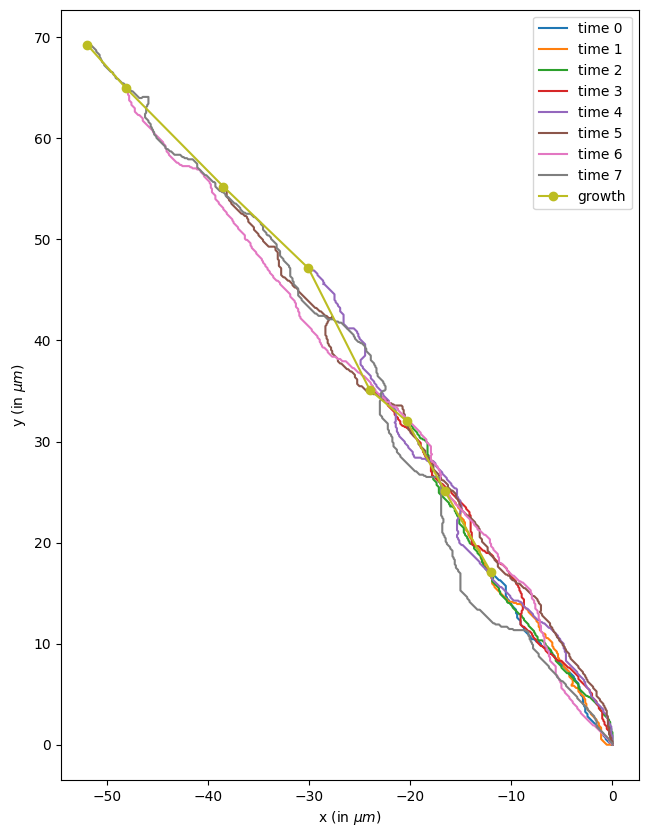

In [9]:
# use matplotlib to plot the axons
fig, ax = plt.figure(figsize=(10,10)), plt.axes()
for i, axon in enumerate(shifted_axons):
    ax.plot(axon[:,0], axon[:,1], label = 'time ' + str(i))
    
ax.plot(growth[:,0], growth[:,1], 'o-', label='growth')
ax.legend()
ax.set_aspect('equal')
# set x and y titles
ax.set_xlabel('x (in $\mu m$)')
ax.set_ylabel('y (in $\mu m$)')
plt.show()

The below cell would compute the required parameters for each time point.

In [10]:
# check if there is already a file with measurements
if os.path.isfile(f'measurements.csv'):
    measurements = pd.read_csv('measurements.csv')
    # create dictionary from the dataframe
    measurements = measurements.to_dict('list')
else:
    measurements = defaultdict(list) # set measurements dictionary

# set columns names 
columns = ['Name of a measurement', 'Time', 'Coordinate of the tip node', 'Axon length ($\mu m$)', 'Speed from $t_{i-1}$ to $t_{i}$ ($\mu m / \text{sec}$)',
        'Axon growth distance from $t_{i-1}$ to $t_{i}$ ($\mu m$)',  'Angle change from $t_{i-1}$ to $t_{i}$ (%)', 'Total growth during all time ($\mu m$)', 
        'Total speed during all time ($\mu m / \text{sec}$)', 'Total angle change (%)']

origin = shifted_axons[0][0] # set origin
prev_tip = origin

measurements = measure(shifted_axons, measurements, prev_tip, columns, origin, name)

time: 0
last tip is [-12.011393  17.062913]
axon growth at time 0 is 20.866637530901265
speed of growth at time 0 is 0
angle change at time 0 is 0
time: 1
last tip is [-16.61389   25.145346]
axon growth at time 1 is 30.138177887719348
speed of growth at time 1 is 9.301005420625135
angle change at time 1 is 174.51558169744104
time: 2
last tip is [-20.318338  31.992962]
axon growth at time 2 is 37.89966327839455
speed of growth at time 2 is 7.785420982076706
angle change at time 2 is 178.75354990227237
time: 3
last tip is [-24.022786  35.136131]
axon growth at time 3 is 42.563387422184306
speed of growth at time 3 is 4.858234900379458
angle change at time 3 is 158.72677059625053
time: 4
last tip is [-30.084611  47.147525]
axon growth at time 4 is 55.92828383427249
speed of growth at time 4 is 13.454341609824722
angle change at time 4 is 157.09294952460212
time: 5
last tip is [-38.503812  55.229957]
axon growth at time 5 is 67.32675314281234
speed of growth at time 5 is 11.67084626379016


Next cell is not compulsory and can be used to visualize the computed data.

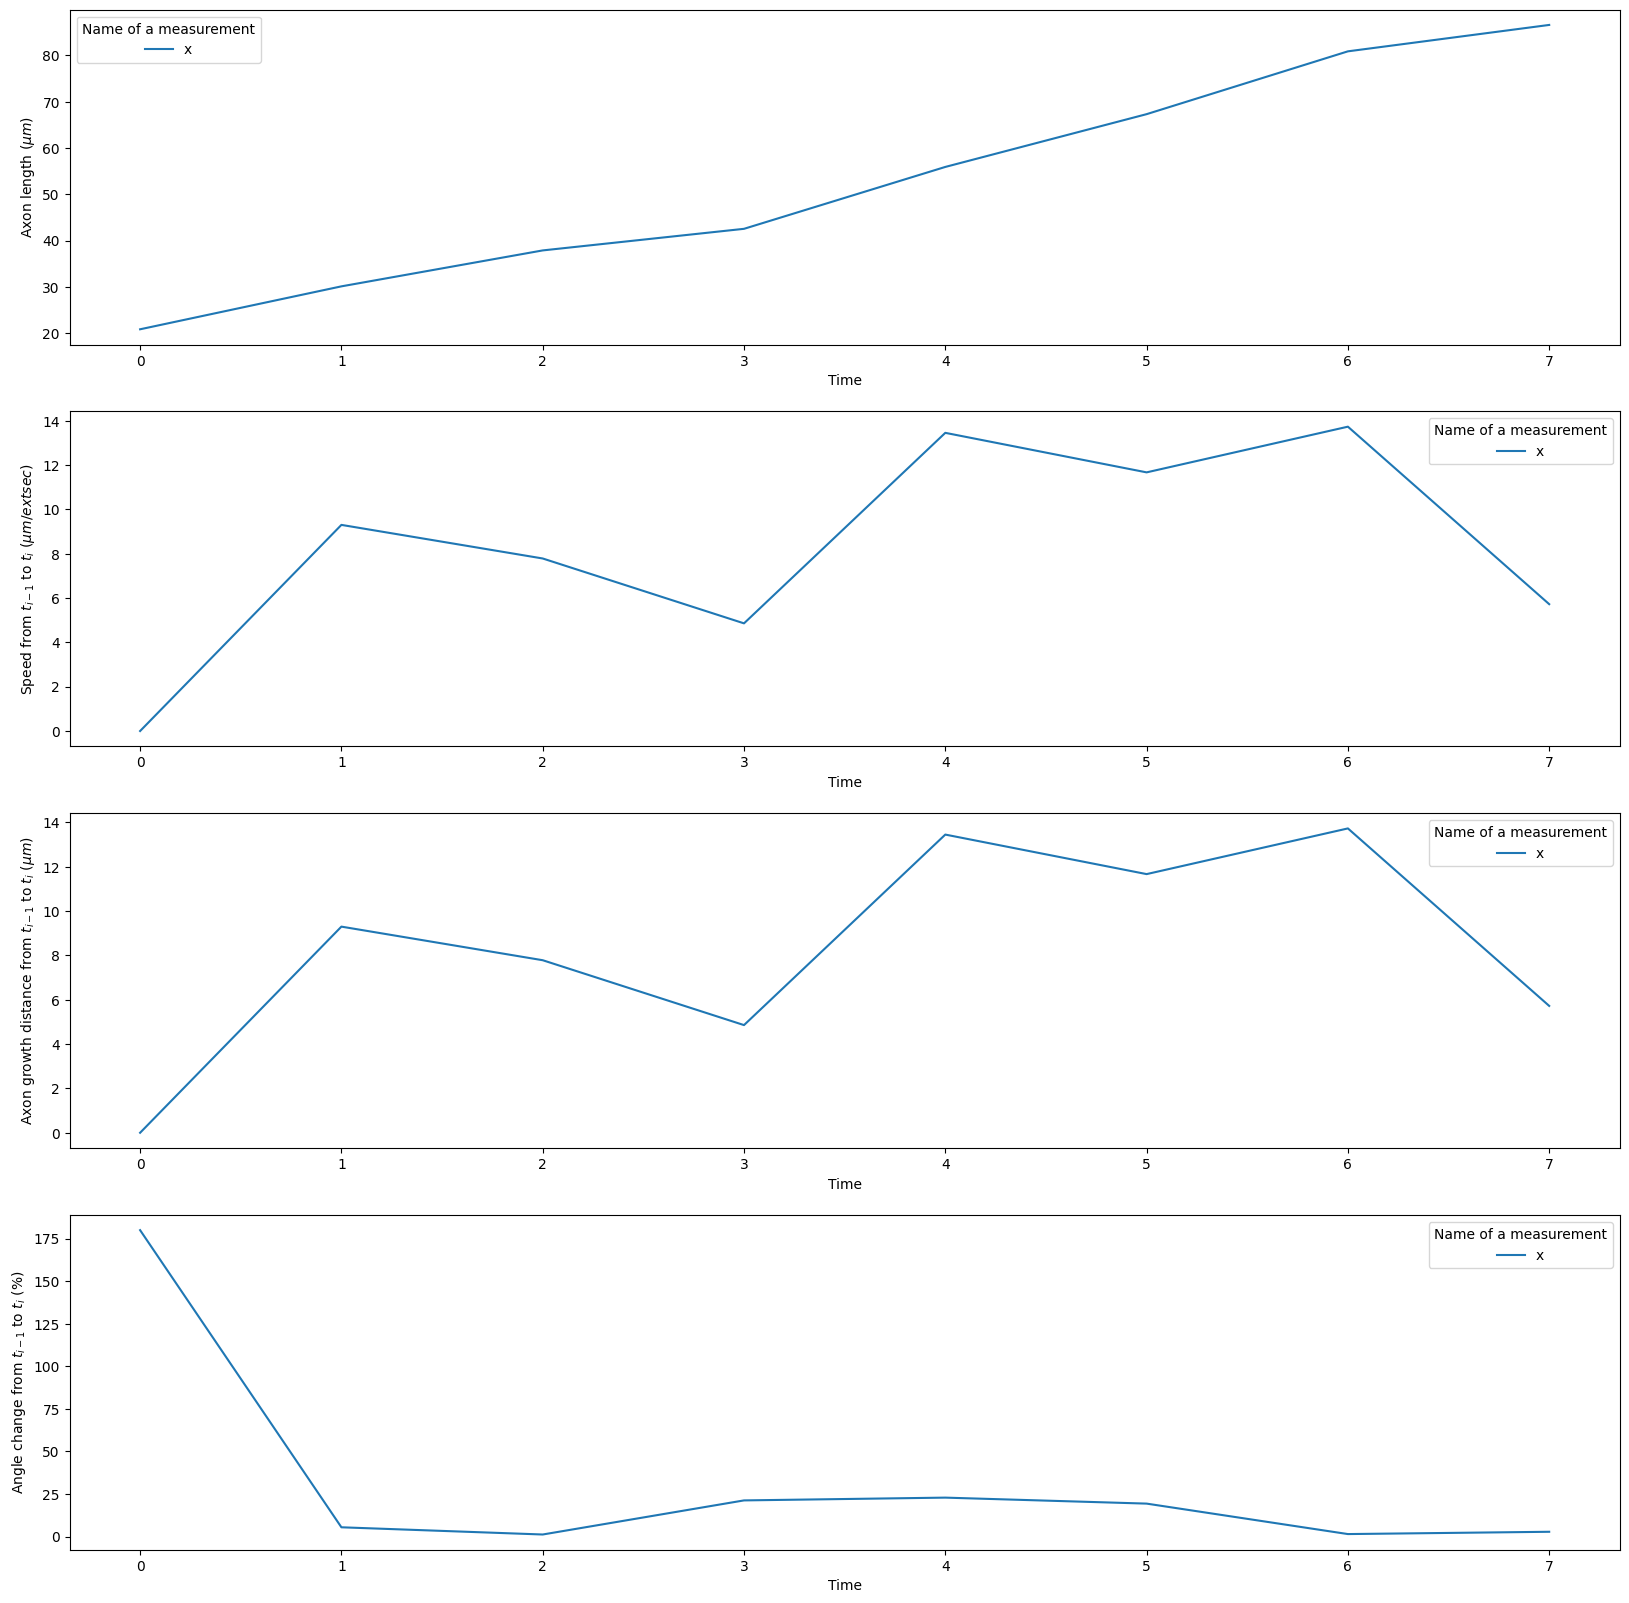

In [11]:
columns_to_show = ['Axon length ($\mu m$)', 'Speed from $t_{i-1}$ to $t_{i}$ ($\mu m / \text{sec}$)',
        'Axon growth distance from $t_{i-1}$ to $t_{i}$ ($\mu m$)',  'Angle change from $t_{i-1}$ to $t_{i}$ (%)']

# visualize all columns in a single plot
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
for i, column in enumerate(columns_to_show):
    sns.lineplot(x=columns[1], y=column, data=measurements, ax=ax[i], hue='Name of a measurement')

In [12]:
measurements

,Name of a measurement,Time,Coordinate of the tip node,Axon length ($\mu m$),Speed from $t_{i-1}$ to $t_{i}$ ($\mu m / \text{sec}$),Axon growth distance from $t_{i-1}$ to $t_{i}$ ($\mu m$),Angle change from $t_{i-1}$ to $t_{i}$ (%),Total growth during all time ($\mu m$),Total speed during all time ($\mu m / \text{sec}$),Total angle change (%)
0,x,0,"[-12.011392999999998, 17.06291299999998]",20.866638,0.000000,0.000000,180.000000,NaN,NaN,NaN
1,x,1,"[-16.613889999999998, 25.14534599999999]",30.138178,9.301005,9.301005,5.484418,NaN,NaN,NaN
2,x,2,"[-20.318337999999997, 31.992962000000006]",37.899663,7.785421,7.785421,1.246450,NaN,NaN,NaN
3,x,3,"[-24.022785999999996, 35.136131000000006]",42.563387,4.858235,4.858235,21.273229,NaN,NaN,NaN
4,x,4,"[-30.084610999999995, 47.147525]",55.928284,13.454342,13.454342,22.907050,NaN,NaN,NaN
5,x,5,"[-38.503811999999996, 55.229956999999985]",67.326753,11.670846,11.670846,19.390302,NaN,NaN,NaN
6,x,6,"[-48.157828, 64.99623]",80.893055,13.732447,13.732447,1.500331,NaN,NaN,NaN
7,x,7,"[-51.974533, 69.26195799999999]",86.594289,5.723956,5.723956,2.848634,65.740344,8.217543,90.0
